In [1]:
import matplotlib

%matplotlib notebook
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook
from sklearn.svm import SVR

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
from mayavi import mlab

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
features_filename = '39-features.xlsx'

In [3]:
df = pd.read_excel(features_filename, index_col=0)

In [4]:
p1 = np.percentile(df['mep_category_cmap'], 33.33)
p2 = np.percentile(df['mep_category_cmap'], 66.66)
cat = np.ones(len(df['mep_category_cmap'])) * ((df['mep_category_cmap'] >= p1) & (df['mep_category_cmap'] < p2))
cat = 2 * (df['mep_category_cmap'] >= p2) * np.ones(len(df['mep_category_cmap'])) + cat
df['mep_category_cmap_across_subjects'] = cat

# Histogram

In [5]:
mep_metric = 'mep_category_cmap_across_subjects'

In [6]:
df.head()

,all_all_max_amplitude,all_all_max_power,all_all_max_power_freq,all_alpha_max_amplitude,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,...,wavelet_central_max_power_time,wavelet_ltm1_max_power_at_freq,wavelet_ltm1_max_power_at_time,wavelet_ltm1_max_power_freq,wavelet_ltm1_max_power_time,wavelet_rtm1_max_power_at_freq,wavelet_rtm1_max_power_at_time,wavelet_rtm1_max_power_freq,wavelet_rtm1_max_power_time,mep_category_cmap_across_subjects
0,0.000002,2.777808e-16,36,0.000002,1.656928e-16,10,6.341239e-17,26,5.535620e-17,4,...,389.247039,9.290681,-0.203200,795.413564,391.136163,0.976562,-0.260847,920.688314,205.866166,2.0
1,0.000002,7.045166e-16,10,0.000002,7.045166e-16,10,3.202701e-16,22,1.251420e-16,2,...,412.348892,11.048543,-0.074716,2749.205329,869.753544,15.625000,-0.341944,874.440057,279.965552,1.0
2,0.000002,4.643096e-16,24,0.000002,1.054613e-16,10,4.643096e-16,24,3.785974e-16,4,...,407.994715,2.129898,-0.179751,2413.468286,1359.271661,17.039183,-0.176331,822.499312,317.586076,1.0
3,0.000002,6.469294e-16,18,0.000002,6.144056e-16,10,6.469294e-16,18,3.054810e-16,2,...,221.358686,18.581361,-0.500718,1147.498869,447.783394,1.953125,-0.117707,846.045450,335.391806,1.0
4,0.000002,8.671570e-16,34,0.000002,3.254531e-16,8,7.122134e-16,26,2.245107e-16,2,...,1182.716816,7.812500,-0.102074,1469.422729,698.547856,1.161335,-0.206620,2639.615189,646.149552,1.0


In [7]:
df2 = df
bins = [0, 4, 8, 12, 20, 30, 46, 70]

In [8]:
def categorize_by_freq_time(df2, bins = [0, 4, 8, 12, 20, 30, 46, 70], time_bins=np.linspace(-500, 0, 11)):
    df2['wavelet_all_max_power_at_freq_bin'] = pd.cut(df2['wavelet_all_max_power_at_freq'], bins)
    df2['wavelet_all_max_power_at_time_bin'] = pd.cut(df2['wavelet_all_max_power_at_time'], time_bins/1000)
    
    df2['wavelet_ltm1_max_power_at_freq_bin'] = pd.cut(df2['wavelet_ltm1_max_power_at_freq'], bins)
    df2['wavelet_ltm1_max_power_at_time_bin'] = pd.cut(df2['wavelet_ltm1_max_power_at_time'], time_bins/1000)
    
    df2['wavelet_rtm1_max_power_at_freq_bin'] = pd.cut(df2['wavelet_rtm1_max_power_at_freq'], bins)
    df2['wavelet_rtm1_max_power_at_time_bin'] = pd.cut(df2['wavelet_rtm1_max_power_at_time'], time_bins/1000)
    return df2

def groupby_freq_time(df, channel='ltm1'):
    df = pd.DataFrame(df.to_records())
    df['wavelet_' + channel + '_max_power_at_freq_bin_left'] = df['wavelet_' + channel + '_max_power_at_freq_bin'].apply(lambda x: x.left)
    df['wavelet_' + channel + '_max_power_at_time_bin_left'] = df['wavelet_' + channel + '_max_power_at_time_bin'].apply(lambda x: x.left)
    df = df.fillna(0)
    return df

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

<IPython.core.display.Javascript object>


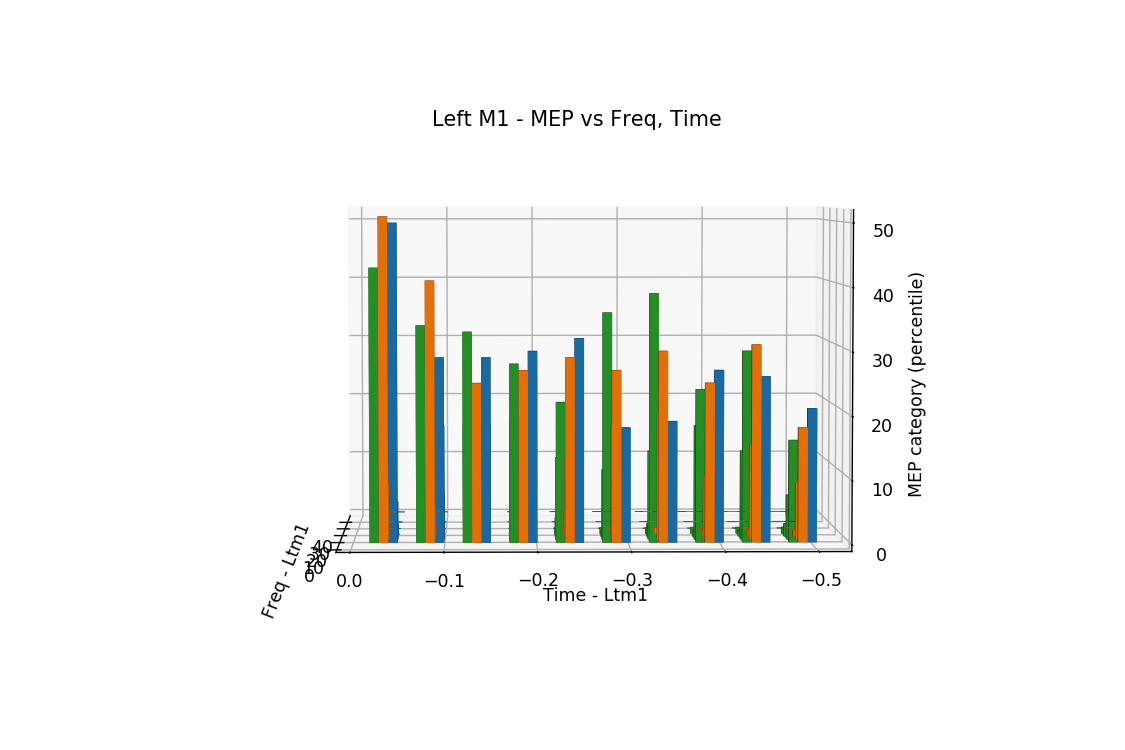

In [9]:
df_percentile_small = categorize_by_freq_time(df2[df2[mep_metric] == 0]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_at_time_bin']).count()
df_percentile_small = groupby_freq_time(df_percentile_small, 'ltm1')

df_percentile_medium = categorize_by_freq_time(df2[df2[mep_metric] == 1]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_at_time_bin']).count()
df_percentile_medium = groupby_freq_time(df_percentile_medium, 'ltm1')

df_percentile_large = categorize_by_freq_time(df2[df2[mep_metric] == 2]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_at_time_bin']).count()
df_percentile_large = groupby_freq_time(df_percentile_large, 'ltm1')


time_width = 0.01
freq_width = 1.2
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.bar3d(df_percentile_small['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_small['wavelet_ltm1_max_power_at_time_bin_left'], np.zeros_like(df_percentile_small['ltm1_all_max_amplitude']), freq_width, time_width, df_percentile_small['ltm1_all_max_amplitude'], shade=True)
ax.bar3d(df_percentile_medium['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_medium['wavelet_ltm1_max_power_at_time_bin_left'] + time_width, np.zeros_like(df_percentile_medium['ltm1_all_max_amplitude']), freq_width, time_width, df_percentile_medium['ltm1_all_max_amplitude'], shade=True)
ax.bar3d(df_percentile_large['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_large['wavelet_ltm1_max_power_at_time_bin_left'] + time_width * 2, np.zeros_like(df_percentile_large['ltm1_all_max_amplitude']), freq_width, time_width, df_percentile_large['ltm1_all_max_amplitude'], shade=True)
ax.set_title('Left M1 - MEP vs Freq, Time')
ax.set_xlabel('Freq - Ltm1')
ax.set_ylabel('Time - Ltm1')
ax.set_zlabel('MEP category (percentile)');

In [10]:
df_percentile_small['wavelet_ltm1_max_power_at_freq_bin'].unique()

array([Interval(0, 4, closed='right'), Interval(4, 8, closed='right'),
       Interval(8, 12, closed='right'), Interval(12, 20, closed='right'),
       Interval(20, 30, closed='right'), Interval(30, 46, closed='right'),
       Interval(46, 70, closed='right')], dtype=object)

<IPython.core.display.Javascript object>


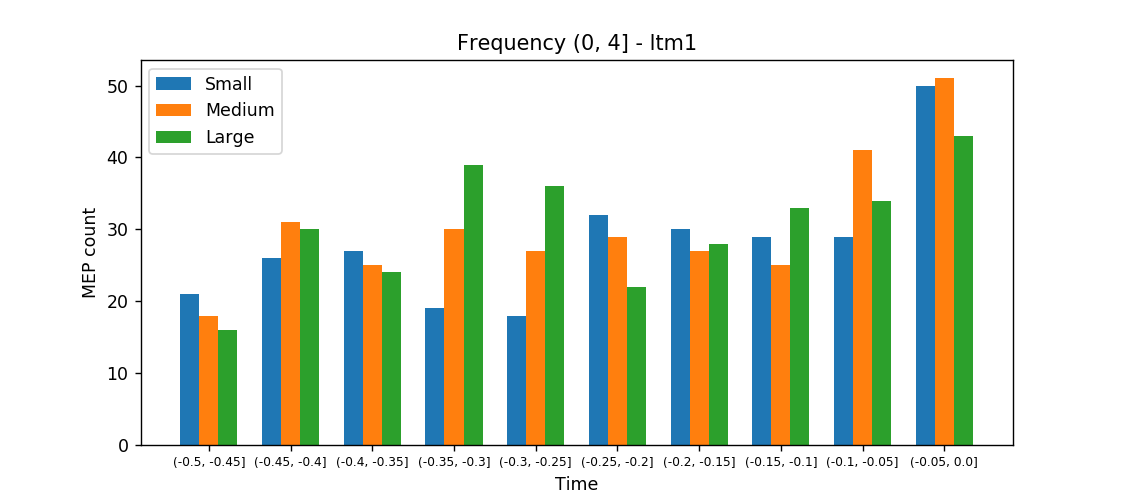

<IPython.core.display.Javascript object>


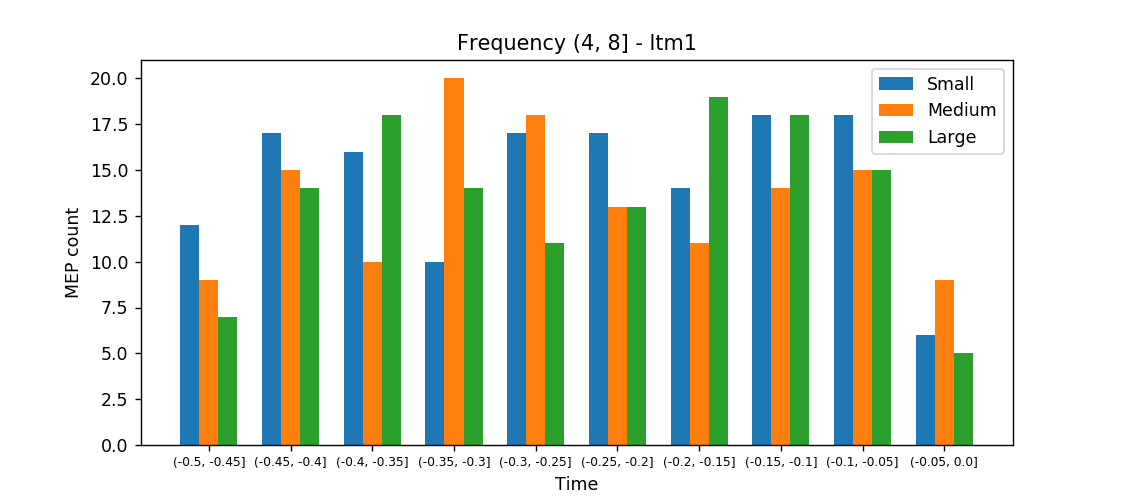

<IPython.core.display.Javascript object>


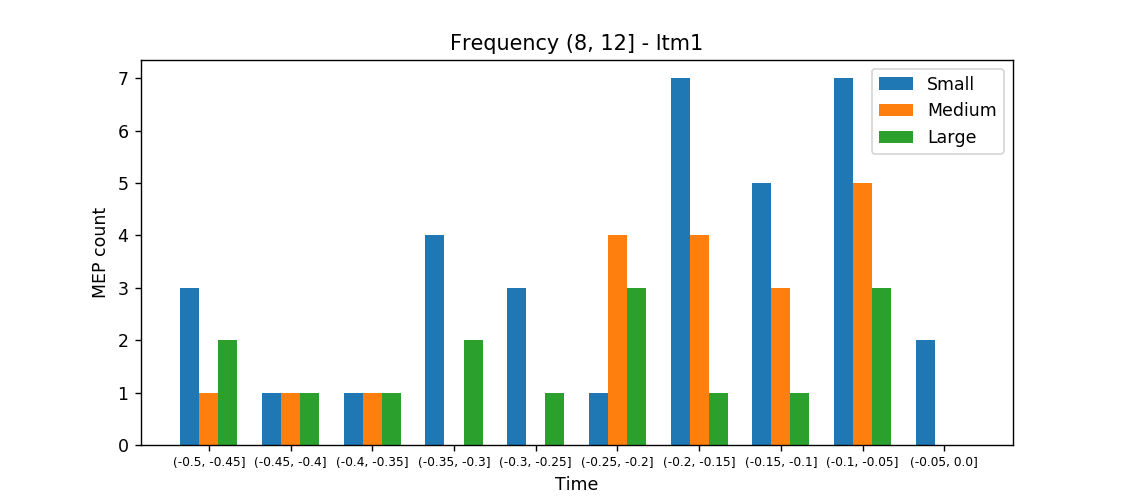

<IPython.core.display.Javascript object>


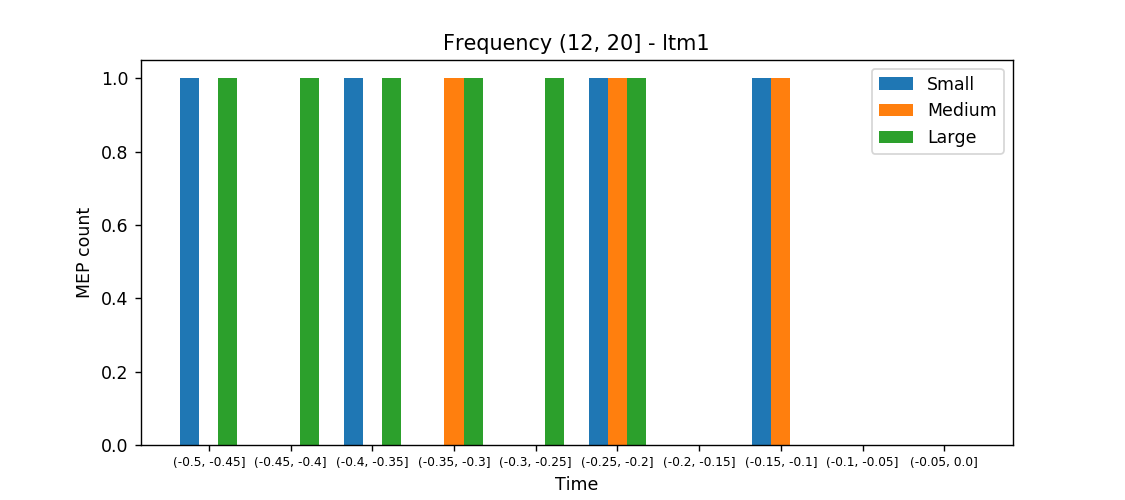

In [11]:
def plot_mep_bar_chart_across_time(freq_range='(0, 4]', channel='ltm1'):
    df_small = df_percentile_small[df_percentile_small['wavelet_' + channel + '_max_power_at_freq_bin'].astype(str) == freq_range]
    ind = np.arange(df_small.shape[0])
    width = 0.35
    fig, ax = plt.subplots(figsize=(9,4))
    ax.bar(ind * 1.5, df_small[channel + '_all_max_amplitude'], width, label='Small')

    df_medium = df_percentile_medium[df_percentile_medium['wavelet_' + channel + '_max_power_at_freq_bin'].astype(str) == freq_range]
    ax.bar(ind * 1.5 + width, df_medium[channel + '_all_max_amplitude'], width, label='Medium')

    df_large = df_percentile_large[df_percentile_large['wavelet_' + channel + '_max_power_at_freq_bin'].astype(str) == freq_range]
    ax.bar(ind * 1.5 + 2*width, df_large[channel + '_all_max_amplitude'], width, label='Large')

    ax.set_xlabel('Time')
    ax.set_ylabel('MEP count')
    ax.set_title('Frequency ' + freq_range + ' - ' + channel)
    ax.set_xticks(ind * 1.5 + width)
    ax.set_xticklabels(df_small['wavelet_' + channel + '_max_power_at_time_bin'], fontdict={'fontsize':7})
    ax.legend()

plot_mep_bar_chart_across_time('(0, 4]', 'ltm1')
plot_mep_bar_chart_across_time('(4, 8]', 'ltm1')
plot_mep_bar_chart_across_time('(8, 12]', 'ltm1')
plot_mep_bar_chart_across_time('(12, 20]', 'ltm1')

In [12]:
print(df2['wavelet_all_max_power_freq'].min())
print(df2['wavelet_all_max_power_freq'].max())

print(df2['wavelet_ltm1_max_power_freq'].min())
print(df2['wavelet_ltm1_max_power_freq'].max())

print(df2['wavelet_rtm1_max_power_freq'].min())
print(df2['wavelet_rtm1_max_power_freq'].max())

3.726550481103787e-14
2.535198074977731e-11
41.2785069273763
18869.33970673751
38.54800179827993
971047.2892801213


<IPython.core.display.Javascript object>


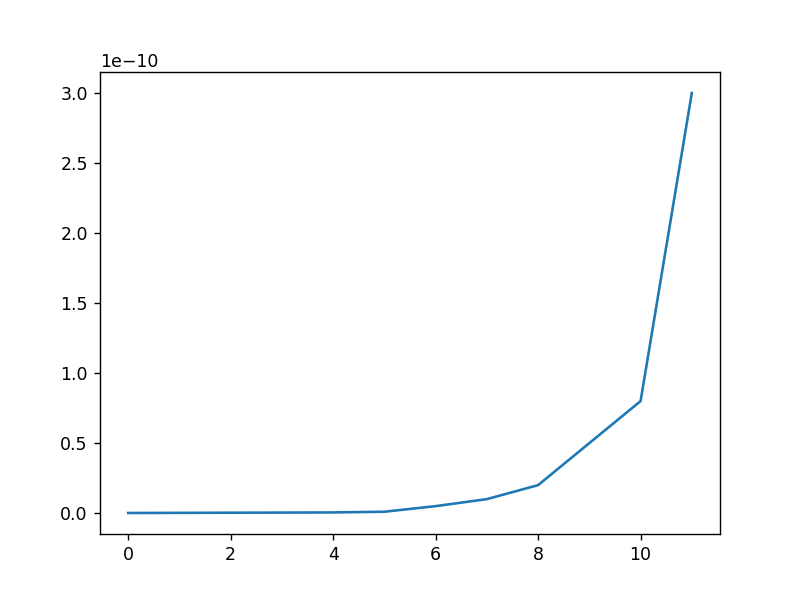

In [13]:
plt.figure()
plt.plot([1.0000e-13, 2.0000e-13, 3.0000e-13, 4e-13, 5e-13, 10e-13, 50e-13, 100e-13, 200e-13, 500e-13, 800e-13, 3000e-13])

In [13]:
np.linspace(0, 0.2e-11, 11)

array([0.0e+00, 2.0e-13, 4.0e-13, 6.0e-13, 8.0e-13, 1.0e-12, 1.2e-12,
       1.4e-12, 1.6e-12, 1.8e-12, 2.0e-12])

In [14]:
def categorize_by_freq_power(df2, bins=[0, 4, 8, 12, 20, 30, 46, 70]):
    df2['wavelet_all_max_power_at_freq_bin'] = pd.cut(df2['wavelet_all_max_power_at_freq'], bins)
    df2['wavelet_all_max_power_freq_bin'] = pd.cut(df2['wavelet_all_max_power_freq'], np.linspace(0, 0.2e-11, 11))
    
    df2['wavelet_ltm1_max_power_at_freq_bin'] = pd.cut(df2['wavelet_ltm1_max_power_at_freq'], bins)
    df2['wavelet_ltm1_max_power_freq_bin'] = pd.cut(df2['wavelet_ltm1_max_power_freq'], [0, 1000, 2000, 3000, 4000, 6000, 8000, 12000, 20000, 40000])
    
    df2['wavelet_rtm1_max_power_at_freq_bin'] = pd.cut(df2['wavelet_rtm1_max_power_at_freq'], bins)
    df2['wavelet_rtm1_max_power_freq_bin'] = pd.cut(df2['wavelet_rtm1_max_power_freq'], np.linspace(0, 980000, 11))
    return df2

def groupby_freq_power(df, channel='ltm1'):
    df = pd.DataFrame(df.to_records())
    df['wavelet_' + channel+ '_max_power_at_freq_bin_left'] = df['wavelet_' + channel+ '_max_power_at_freq_bin'].apply(lambda x: x.left)
    df['wavelet_' + channel+ '_max_power_freq_bin_left'] = df['wavelet_' + channel+ '_max_power_freq_bin'].apply(lambda x: x.left)
    df = df.fillna(0)
    return df

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

<IPython.core.display.Javascript object>


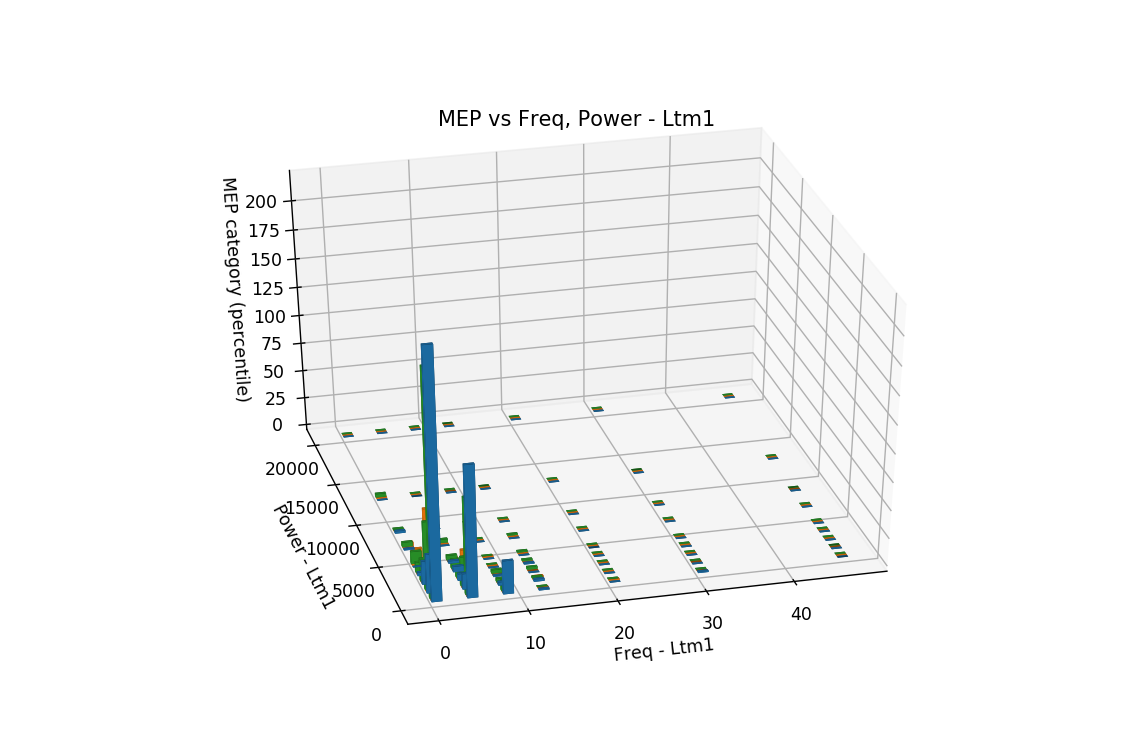

In [15]:
df_percentile_small = categorize_by_freq_power(df2[df2[mep_metric] == 0]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_freq_bin']).count()
df_percentile_small = groupby_freq_power(df_percentile_small)

df_percentile_medium = categorize_by_freq_power(df2[df2[mep_metric] == 1]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_freq_bin']).count()
df_percentile_medium = groupby_freq_power(df_percentile_medium)

df_percentile_large = categorize_by_freq_power(df2[df2[mep_metric] == 2]).groupby(['wavelet_ltm1_max_power_at_freq_bin', 'wavelet_ltm1_max_power_freq_bin']).count()
df_percentile_large = groupby_freq_power(df_percentile_large)

power_width = 200
freq_width = 1.2
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.bar3d(df_percentile_small['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_small['wavelet_ltm1_max_power_freq_bin_left'], np.zeros_like(df_percentile_small['ltm1_all_max_amplitude']), freq_width, power_width, df_percentile_small['ltm1_all_max_amplitude'], shade=True, zorder=0.5)
ax.bar3d(df_percentile_medium['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_medium['wavelet_ltm1_max_power_freq_bin_left'] + power_width, np.zeros_like(df_percentile_medium['ltm1_all_max_amplitude']), freq_width, power_width, df_percentile_medium['ltm1_all_max_amplitude'], shade=True, zorder=0.4)
ax.bar3d(df_percentile_large['wavelet_ltm1_max_power_at_freq_bin_left'], df_percentile_large['wavelet_ltm1_max_power_freq_bin_left'] + power_width * 2, np.zeros_like(df_percentile_large['ltm1_all_max_amplitude']), freq_width, power_width, df_percentile_large['ltm1_all_max_amplitude'], shade=True, zorder=0.3)
ax.set_title('MEP vs Freq, Power - Ltm1')
ax.set_xlabel('Freq - Ltm1')
ax.set_ylabel('Power - Ltm1')
ax.set_zlabel('MEP category (percentile)');

<IPython.core.display.Javascript object>


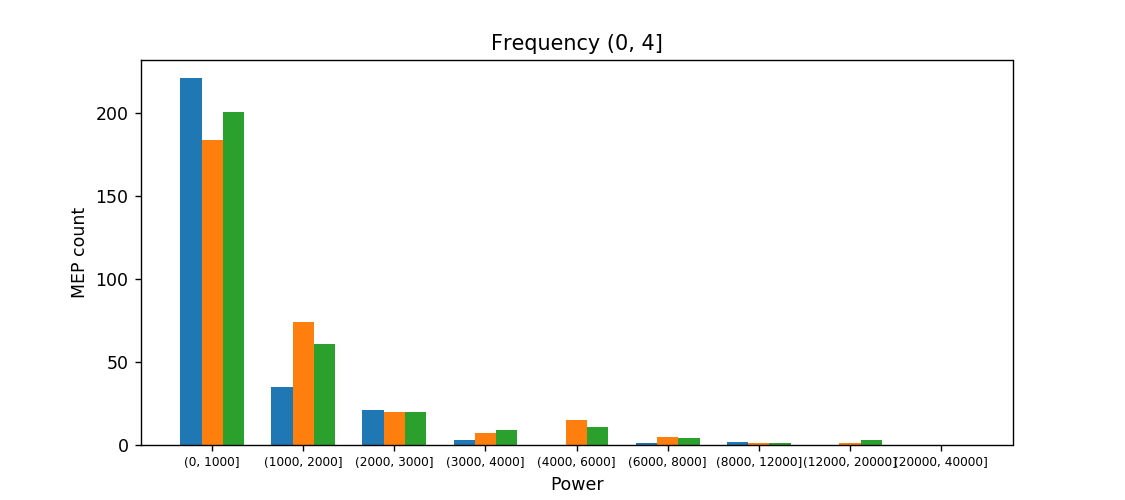

<IPython.core.display.Javascript object>


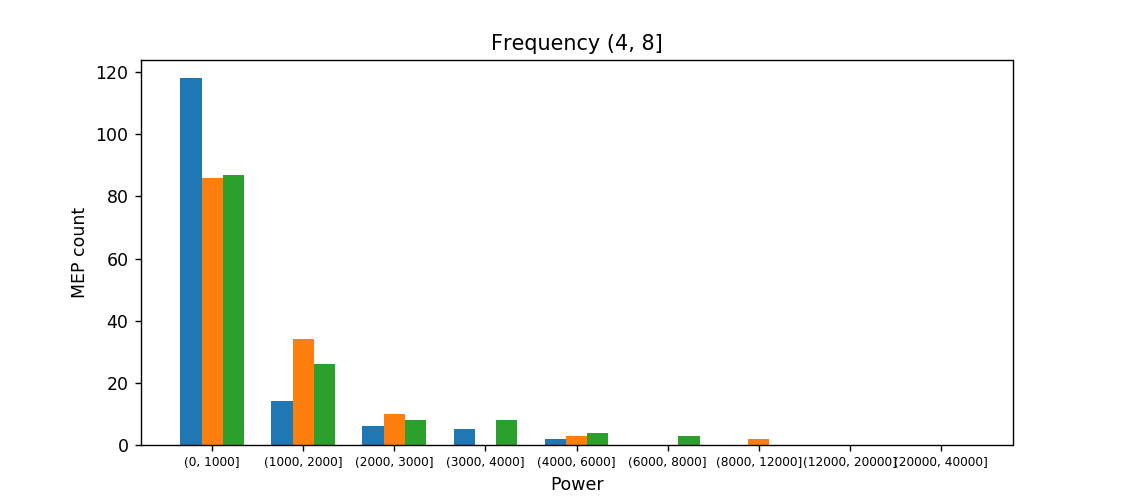

<IPython.core.display.Javascript object>


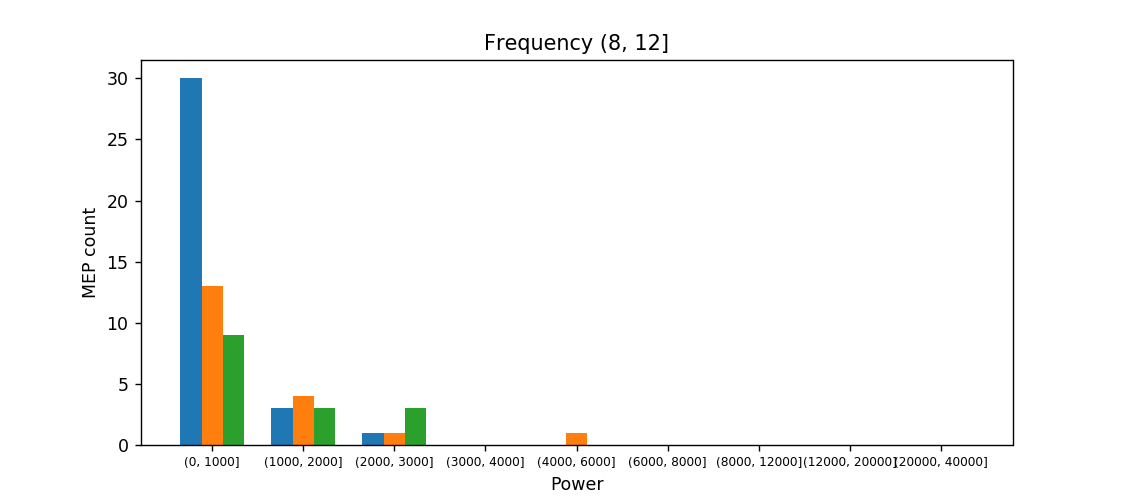

<IPython.core.display.Javascript object>


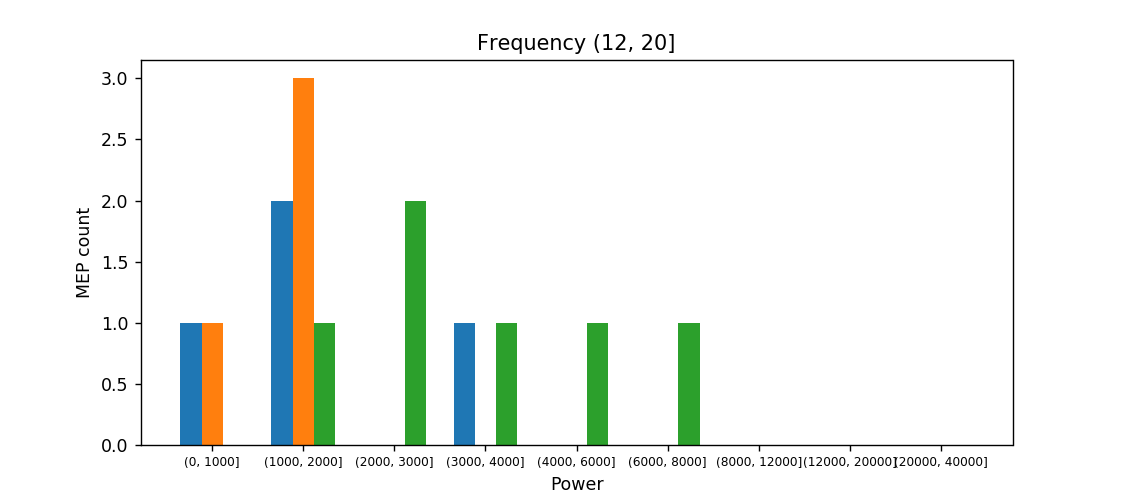

In [16]:
def plot_mep_bar_chart_across_power(freq_range='(0, 4]', channel='ltm1'):
    df_small = df_percentile_small[df_percentile_small['wavelet_' + channel + '_max_power_at_freq_bin'].astype(str) == freq_range]
    ind = np.arange(df_small.shape[0])
    width = 0.35
    fig, ax = plt.subplots(figsize=(9,4))
    ax.bar(ind * 1.5, df_small[channel + '_all_max_amplitude'], width, label='Small')

    df_medium = df_percentile_medium[df_percentile_medium['wavelet_' + channel + '_max_power_at_freq_bin'].astype(str) == freq_range]
    ax.bar(ind * 1.5 + width, df_medium[channel + '_all_max_amplitude'], width, label='Medium')

    df_large = df_percentile_large[df_percentile_large['wavelet_' + channel + '_max_power_at_freq_bin'].astype(str) == freq_range]
    ax.bar(ind * 1.5 + 2*width, df_large[channel + '_all_max_amplitude'], width, label='Large')

    ax.set_xlabel('Power')
    ax.set_ylabel('MEP count')
    ax.set_title('Frequency ' + freq_range)
    ax.set_xticks(ind * 1.5 + width)
    ax.set_xticklabels(df_small['wavelet_' + channel + '_max_power_freq_bin'], fontdict={'fontsize':7})
    
plot_mep_bar_chart_across_power('(0, 4]', 'ltm1')
plot_mep_bar_chart_across_power('(4, 8]', 'ltm1')
plot_mep_bar_chart_across_power('(8, 12]', 'ltm1')
plot_mep_bar_chart_across_power('(12, 20]', 'ltm1')

# All channels

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

<IPython.core.display.Javascript object>


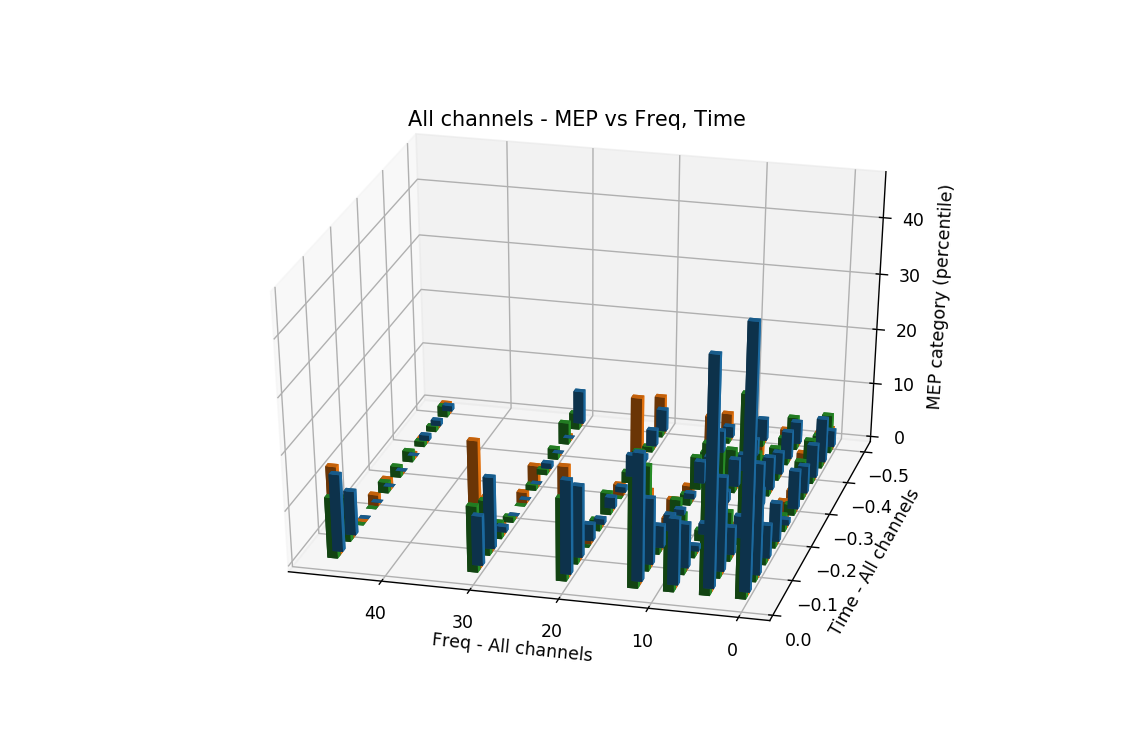

In [17]:
channel = 'all'
df_percentile_small = categorize_by_freq_time(df2[df2[mep_metric] == 0]).groupby(['wavelet_' + channel + '_max_power_at_freq_bin', 'wavelet_' + channel + '_max_power_at_time_bin']).count()
df_percentile_small = groupby_freq_time(df_percentile_small, channel)

df_percentile_medium = categorize_by_freq_time(df2[df2[mep_metric] == 1]).groupby(['wavelet_' + channel + '_max_power_at_freq_bin', 'wavelet_' + channel + '_max_power_at_time_bin']).count()
df_percentile_medium = groupby_freq_time(df_percentile_medium, channel)

df_percentile_large = categorize_by_freq_time(df2[df2[mep_metric] == 2]).groupby(['wavelet_' + channel + '_max_power_at_freq_bin', 'wavelet_' + channel + '_max_power_at_time_bin']).count()
df_percentile_large = groupby_freq_time(df_percentile_large, channel)


time_width = 0.01
freq_width = 1.2
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.bar3d(df_percentile_small['wavelet_' + channel + '_max_power_at_freq_bin_left'], df_percentile_small['wavelet_' + channel + '_max_power_at_time_bin_left'], np.zeros_like(df_percentile_small[channel + '_all_max_amplitude']), freq_width, time_width, df_percentile_small[channel + '_all_max_amplitude'], shade=True)
ax.bar3d(df_percentile_medium['wavelet_' + channel + '_max_power_at_freq_bin_left'], df_percentile_medium['wavelet_' + channel + '_max_power_at_time_bin_left'] + time_width, np.zeros_like(df_percentile_medium[channel + '_all_max_amplitude']), freq_width, time_width, df_percentile_medium[channel + '_all_max_amplitude'], shade=True)
ax.bar3d(df_percentile_large['wavelet_' + channel + '_max_power_at_freq_bin_left'], df_percentile_large['wavelet_' + channel + '_max_power_at_time_bin_left'] + time_width * 2, np.zeros_like(df_percentile_large[channel + '_all_max_amplitude']), freq_width, time_width, df_percentile_large[channel + '_all_max_amplitude'], shade=True)
ax.set_title('All channels - MEP vs Freq, Time')
ax.set_xlabel('Freq - All channels')
ax.set_ylabel('Time - All channels')
ax.set_zlabel('MEP category (percentile)');

<IPython.core.display.Javascript object>


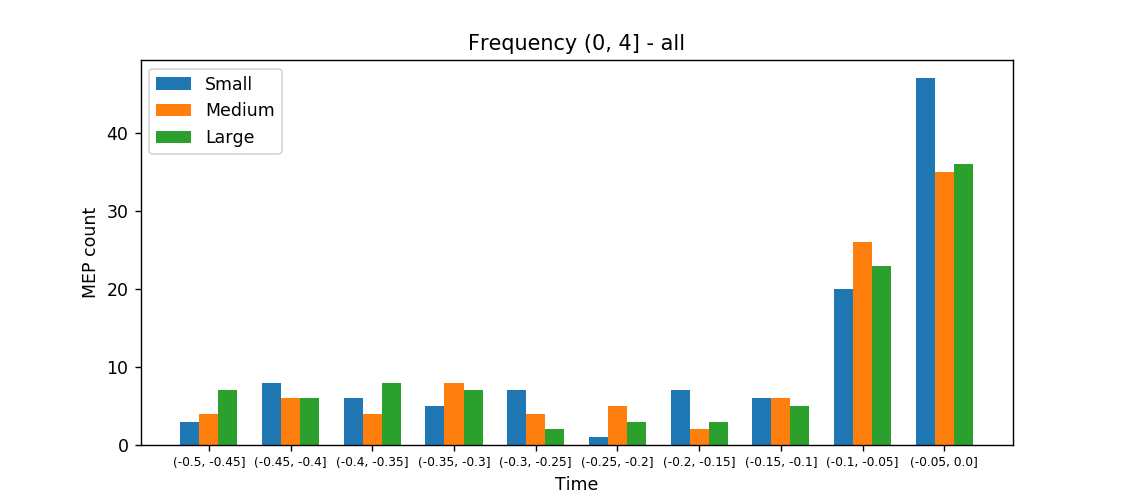

<IPython.core.display.Javascript object>


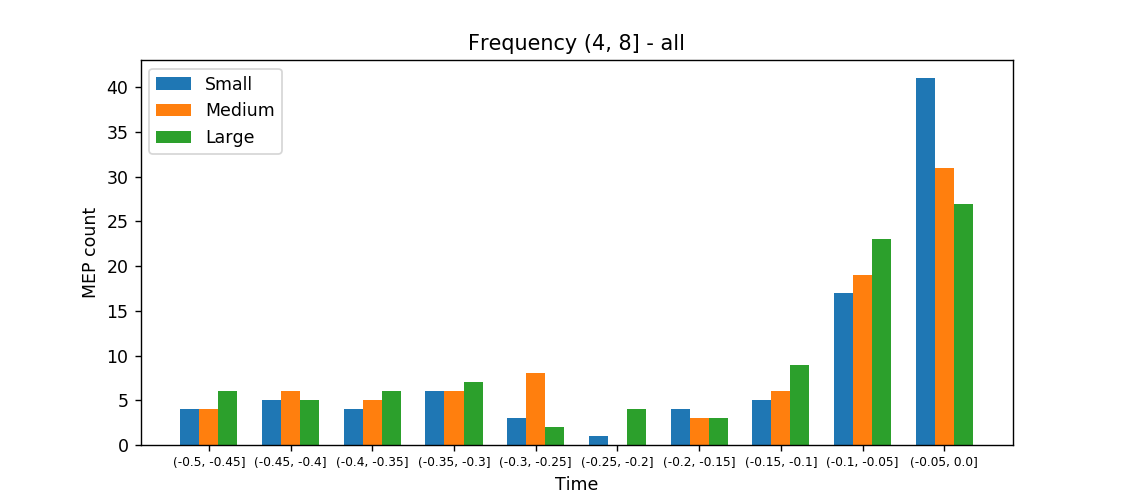

<IPython.core.display.Javascript object>


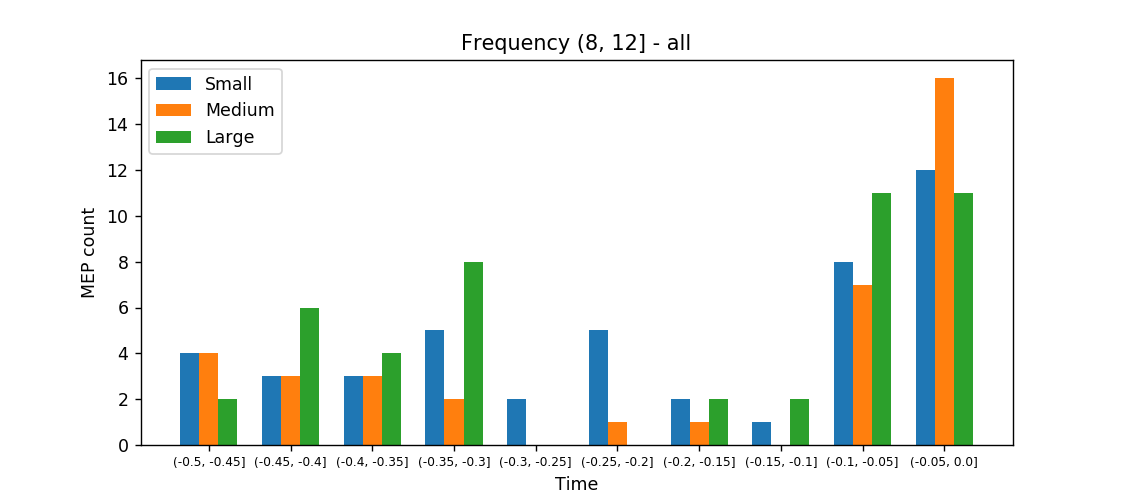

<IPython.core.display.Javascript object>


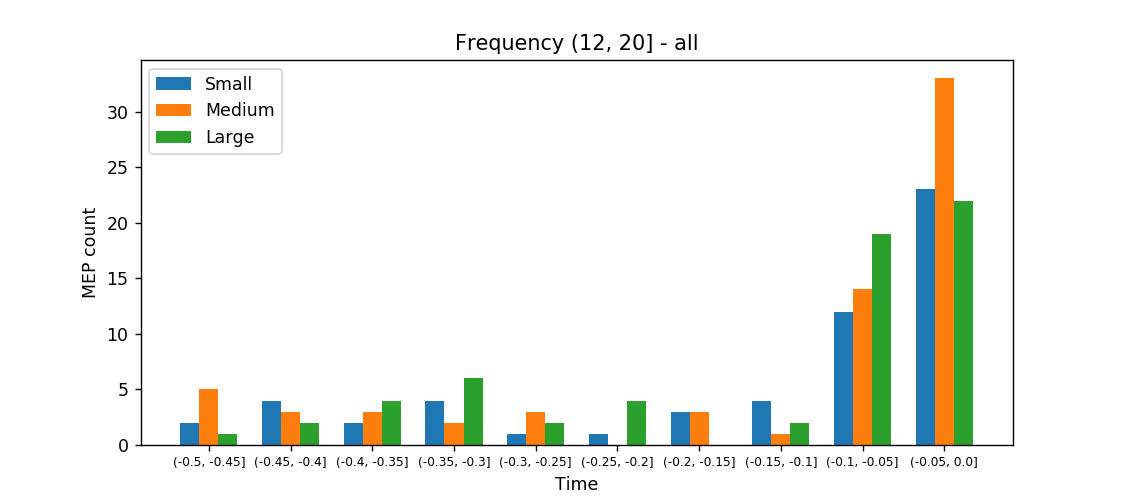

In [18]:
plot_mep_bar_chart_across_time('(0, 4]', 'all')
plot_mep_bar_chart_across_time('(4, 8]', 'all')
plot_mep_bar_chart_across_time('(8, 12]', 'all')
plot_mep_bar_chart_across_time('(12, 20]', 'all')

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

<IPython.core.display.Javascript object>


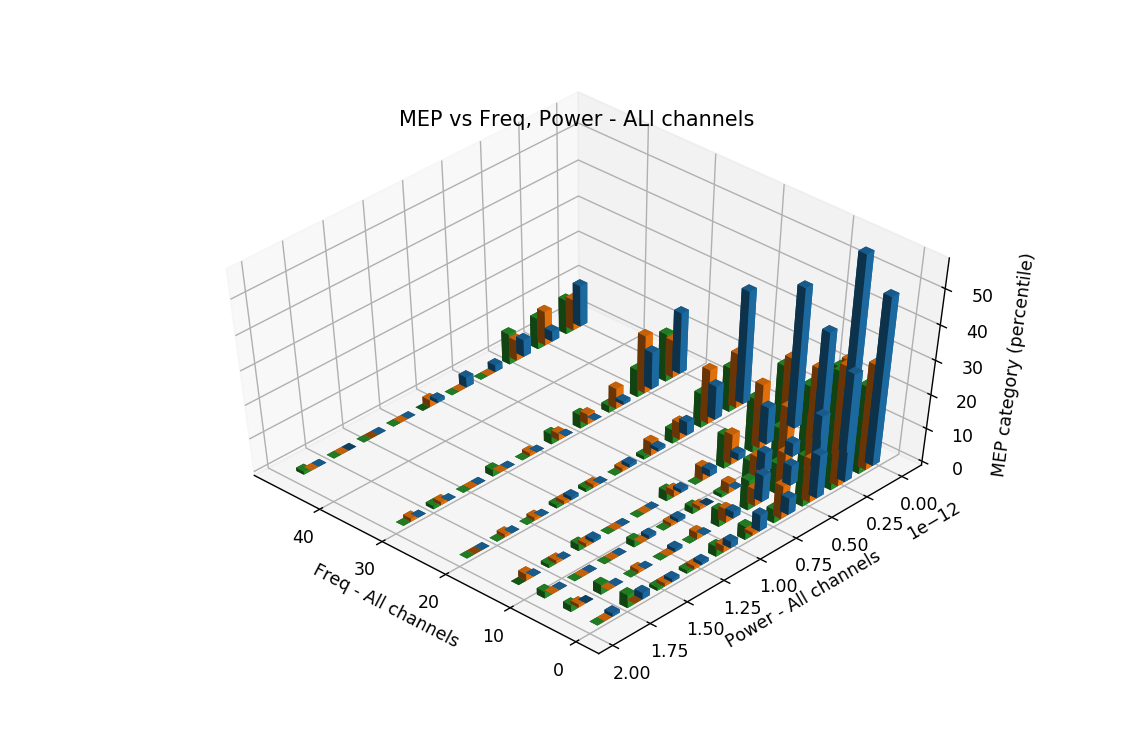

In [20]:
df_percentile_small = categorize_by_freq_power(df2[df2[mep_metric] == 0]).groupby(['wavelet_'+channel+'_max_power_at_freq_bin', 'wavelet_'+channel+'_max_power_freq_bin']).count()
df_percentile_small = groupby_freq_power(df_percentile_small, 'all')

df_percentile_medium = categorize_by_freq_power(df2[df2[mep_metric] == 1]).groupby(['wavelet_'+channel+'_max_power_at_freq_bin', 'wavelet_'+channel+'_max_power_freq_bin']).count()
df_percentile_medium = groupby_freq_power(df_percentile_medium, 'all')

df_percentile_large = categorize_by_freq_power(df2[df2[mep_metric] == 2]).groupby(['wavelet_'+channel+'_max_power_at_freq_bin', 'wavelet_'+channel+'_max_power_freq_bin']).count()
df_percentile_large = groupby_freq_power(df_percentile_large, 'all')

power_width = 0.0005e-10
freq_width = 1.2
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.bar3d(df_percentile_small['wavelet_'+channel+'_max_power_at_freq_bin_left'], df_percentile_small['wavelet_'+channel+'_max_power_freq_bin_left'], np.zeros_like(df_percentile_small[channel+'_all_max_amplitude']), freq_width, power_width, df_percentile_small[channel+'_all_max_amplitude'], shade=True, zorder=0.5)
ax.bar3d(df_percentile_medium['wavelet_'+channel+'_max_power_at_freq_bin_left'], df_percentile_medium['wavelet_'+channel+'_max_power_freq_bin_left'] + power_width, np.zeros_like(df_percentile_medium[channel+'_all_max_amplitude']), freq_width, power_width, df_percentile_medium[channel+'_all_max_amplitude'], shade=True, zorder=0.4)
ax.bar3d(df_percentile_large['wavelet_'+channel+'_max_power_at_freq_bin_left'], df_percentile_large['wavelet_'+channel+'_max_power_freq_bin_left'] + power_width * 2, np.zeros_like(df_percentile_large[channel+'_all_max_amplitude']), freq_width, power_width, df_percentile_large[channel+'_all_max_amplitude'], shade=True, zorder=0.3)
ax.set_title('MEP vs Freq, Power - ALl channels')
ax.set_xlabel('Freq - All channels')
ax.set_ylabel('Power - All channels')
ax.set_zlabel('MEP category (percentile)');

<IPython.core.display.Javascript object>


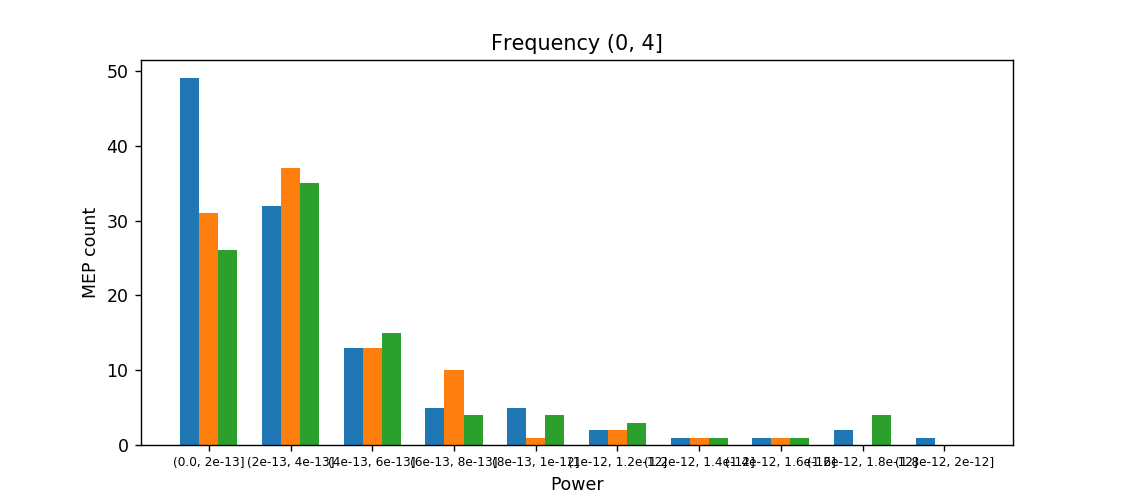

<IPython.core.display.Javascript object>


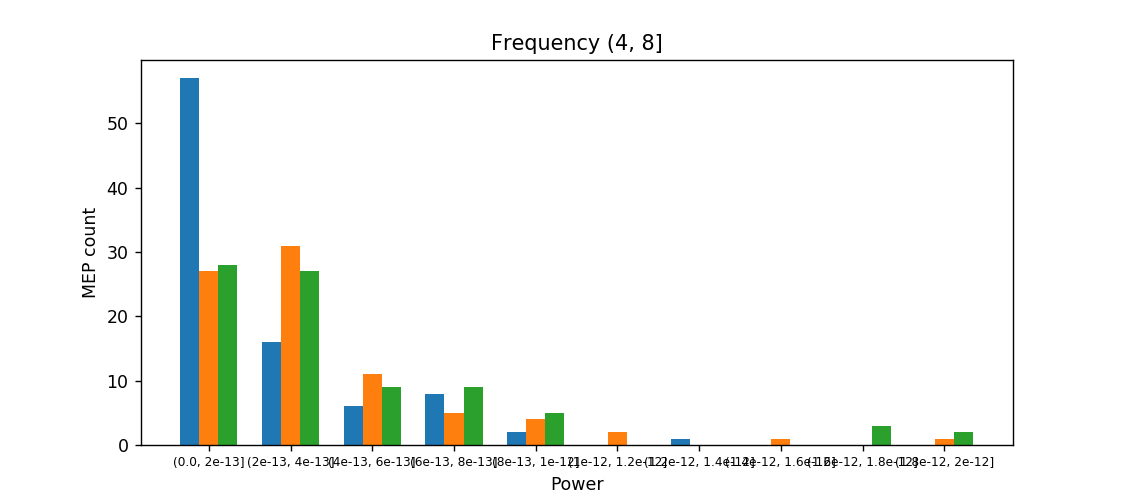

<IPython.core.display.Javascript object>


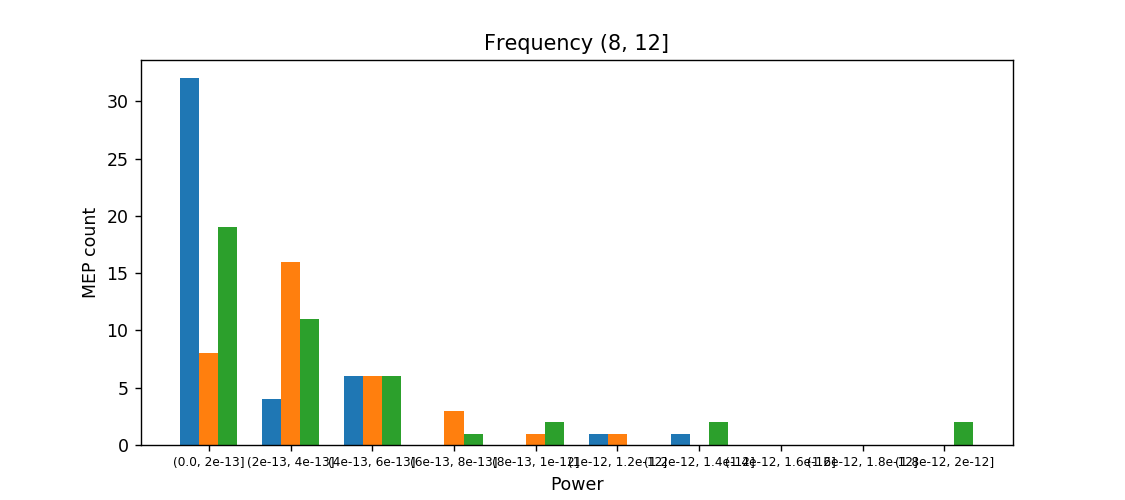

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<IPython.core.display.Javascript object>


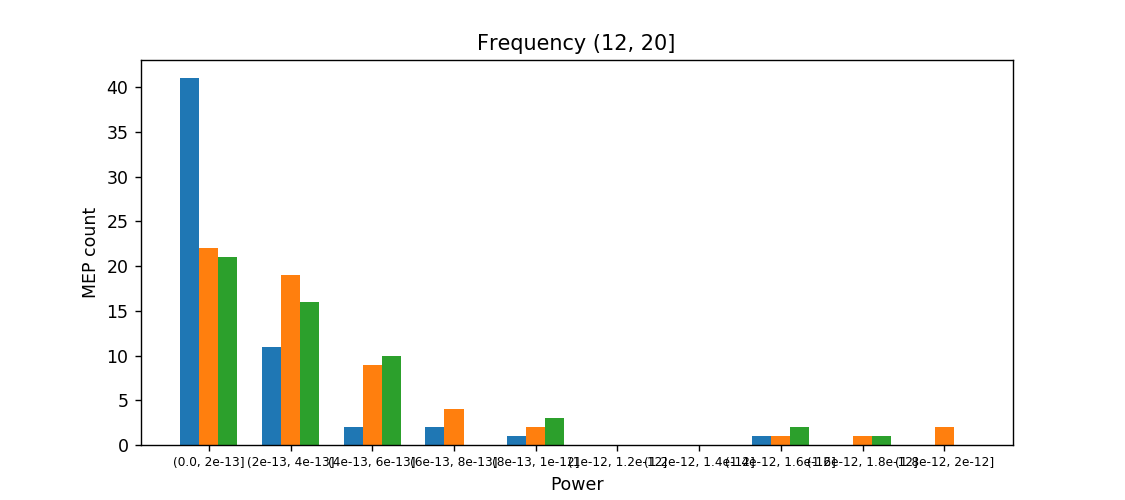

In [21]:
plot_mep_bar_chart_across_power('(0, 4]', 'all')
plot_mep_bar_chart_across_power('(4, 8]', 'all')
plot_mep_bar_chart_across_power('(8, 12]', 'all')
plot_mep_bar_chart_across_power('(12, 20]', 'all')